In [1]:
%%capture

from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, LSTM, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Flatten, Reshape
from keras.layers import Softmax, Input, Concatenate, Embedding, Activation, Lambda
from keras.utils import to_categorical
from keras.optimizers import RMSprop
from keras.models import model_from_json

import cv2
import numpy as np
import random
from collections import deque

import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, COMPLEX_MOVEMENT, RIGHT_ONLY
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import gym
from copy import copy



#HYPER PARAMETERS
BUFFER = 3
PATIENCE = 5
MAX_FRAMES = 3000
STUCK_PENALTY = -50

#SEMI HYPER PARAMETERS
SKIP = 6
LAYER_CHANCE = .33
WEIGHT_CHANCE = .33
MUT_FACTOR = .33
SCORE_FACTOR = .2
agent_id = 0


MOVEMENT = COMPLEX_MOVEMENT
GAME = 'SuperMarioBros-v3'

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144]).astype('int')

def prepare_frames(frames):
    gray_frames = []
    for frame in frames:
        gray_frame = rgb2gray(frame)
        gray_frames.append(gray_frame)
    gray_frames = np.array(gray_frames)
    return np.array([np.swapaxes(gray_frames, 0, 2)])
        
    
class Model:
    
    def __init__(self, input_shape, output_dim, activation = 'relu'):
        w, h, _ = input_shape
        max_dim = max([w,h])    
        
        self.input_shape = input_shape
        self.output_dim = output_dim
        self.NN = Sequential()
        
        
        
        self.NN.add(Lambda(lambda x: x/255., input_shape = input_shape))        
        self.NN.add(ZeroPadding2D(padding = ((max_dim - w)//2, (max_dim - h)//2)))
        self.NN.add(MaxPooling2D((4,4)))
        self.NN.add(Conv2D(8,
                              4,
                              strides=(2, 2),
                              padding="same",
                              activation=activation))
        self.NN.add(Conv2D(16,
                              4,
                              strides=(2, 2),
                              padding="same",
                              activation=activation))
        
        self.NN.add(Conv2D(32,
                              4,
                              strides=(2, 2),
                              padding="same",
                              activation=activation))
        self.NN.add(Flatten())
        self.NN.add(Dense(128, activation=activation))
        self.NN.add(Dense(output_dim, activation = 'softmax'))
        self.NN.compile(loss="mean_squared_error",
                           optimizer = 'rmsprop')
    
    
    def summary(self):
        return self.NN.summary()
    
    def get_weights(self):
        return self.NN.get_weights()
        
        
class mario_agent:
    
    def __init__(self, input_shape, output_dim):
        global agent_id
        self.id = agent_id
        agent_id +=1
        
        self.score_factor = SCORE_FACTOR
        
        self.layer_chance = LAYER_CHANCE
        self.weight_chance = WEIGHT_CHANCE
        self.mut_factor = MUT_FACTOR
        self.skip = SKIP
        
        self.max_frames = MAX_FRAMES
        self.action_space = output_dim
        self.buffer = BUFFER
        self.patience = PATIENCE
        self.fitness = None
        self.w_fitness = 0
        
        self.last_action = []
        self.optography = []
        self.genealogy = deque(maxlen = self.buffer)
        self.model = Model(input_shape, output_dim)
        
    def act(self, frames, prob = False):
        q_values = self.model.NN.predict(frames)
        if prob:
            return q_values[0]
        return np.argmax(q_values[0])
    
    def play(self, render = False, monitor = False):
        env = gym_super_mario_bros.make(GAME)
        env = JoypadSpace(env, MOVEMENT)
        if monitor:
            env = gym.wrappers.Monitor(env, "./gym-results", force=True)
        env.reset()
        
        observation_space = env.observation_space.shape
        action_space = env.action_space.n
        action = 0
        tot_reward = 0
        agg_reward = 0
        reward = 0
        w_reward = 0
         
        stuck = 0
        x_pos = 0
        terminal = False
        first = True
        stuck_bool = False
        
        self.optography = deque(maxlen = self.buffer)
        
        for step in range(self.max_frames):
            if render:
                env.render()
            if not terminal:
                state, reward, terminal, info = env.step(action)
            
            if info['x_pos'] > x_pos:
                x_pos = info['x_pos']
                stuck = 0
            else:
                stuck+=1
            
            if stuck > self.patience*60:
                reward = STUCK_PENALTY
                stuck_bool = True
            
            tot_reward += reward
            agg_reward += reward
            
            if info['stage'] != 1:
                     # serialize model to JSON
                model_json = model.to_json()
                with open("model.json", "w") as json_file:
                    json_file.write(model_json)
                    

            if step % self.skip == 0:
                self.optography.append(np.array(state))

            if len(self.optography) == self.buffer:
                
                if info['life'] < 2:
                    terminal = True
                
                frames = prepare_frames(self.optography)
                q_values = self.act(frames, prob = True)
                w_reward += np.max(q_values)*agg_reward
                agg_reward = 0
                action = np.argmax(q_values)
            
                if terminal or stuck_bool:
                    env.close()
                    self.fitness = tot_reward + info['score']*self.score_factor
                    self.w_fitness = w_reward
                    self.last_action = action
                    return env


        env.close()
        self.fitness = tot_reward + info['score']*self.score_factor
        self.w_fitness = w_reward
        self.last_action = action
        return env
    
    def get_fitness(self):
        if self.fitness == None:
            self.play()
        return self.fitness
    
    def mutate_layer(self, layer):
        weights = []
        for weight in layer.get_weights():
            new_weight = np.random.uniform(-0.05, 0.05, np.shape(weight))
            for index in np.ndenumerate(weight):
                if random.random() < self.weight_chance:
                    weight[index[0]] += new_weight[index[0]]*self.mut_factor
                    weight[index[0]] = min(0.05, weight[index[0]])
                    weight[index[0]] = max(-0.05, weight[index[0]])
            weights.append(weight)
        layer.set_weights(weights)

    def mutate(self):
        self.fitness = None
        for layer in self.model.NN.layers:
            if random.random() < self.layer_chance:
                self.mutate_layer(layer)
                
        
        #self.layer_chance += random.randint(-1,1)*random.random()/10
        #self.weight_chance += random.randint(-1,1)*random.random()/10
        #self.mut_factor += random.randint(-1,1)*random.random()/10
        self.skip = max(1,SKIP + random.randint(-1,1))

In [2]:
import matplotlib.pyplot as plt

fitness_hist = []

env = gym_super_mario_bros.make(GAME)
env = JoypadSpace(env, MOVEMENT)
observation_space = env.observation_space.shape
action_space = env.action_space.n
agent = mario_agent((256, 240, BUFFER), action_space)

In [3]:
agent.model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 256, 240, 3)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 256, 256, 3)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 8)         392       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 16)        2064      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 32)          8224      
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)             

In [4]:
from copy import copy

def update_ancestor(agent1, agent2):
    if agent1.fitness != agent2.fitness:
        genealogy = agent1.genealogy
        genealogy.append((agent1.id, agent1.fitness))
        agent2.genealogy = genealogy

def transfer_weights(NN1, NN2):
    for i in range(len(NN1.layers)):
        NN2.layers[i].set_weights(copy(NN1.layers[i].get_weights()))
        
def same_last_action(agent):
    frames = prepare_frames(agent.optography)
    action = agent.act(frames)
    return action == agent.last_action
        
def replicate(agent1, agent2, flashback = False, verbose = False):
    update_ancestor(agent1, agent2)
    transfer_weights(agent1.model.NN, agent2.model.NN)
    
    if flashback:
        attempts = 0
        while(same_last_action(agent2)):
            agent2.mutate()
            if verbose:
                clear_output(wait = True)
                attempts += 1
                print("Mutation Attempts: ", attempts)
    else:
        agent2.mutate()

    agent2.fitness = None
    
    global agent_id
    agent2.id = agent_id
    agent_id += 1
    
def get_next_gen(generation, flashback = False, verbose = False):
    for l in range(LIV_SIZE):
        for g in range(int(GEN_SIZE/LIV_SIZE) - 1):
            #print(l, (l+1)*LIV_SIZE + g)
            agent1 = generation[l]
            agent2 = generation[(l+1)*LIV_SIZE + g]
            replicate(agent1, agent2, flashback = flashback, verbose = verbose)

In [5]:
import operator

def generation_step(generation, flashback = False, verbose = False):
    gen_fitness = [agent.get_fitness() for agent in generation]
    w_fitness = [agent.w_fitness for agent in generation]
    zipped = zip(generation, gen_fitness, w_fitness)
    gen_sorted = list(reversed(sorted(zipped, key = operator.itemgetter(1, 2))))
    generation, gen_fitness, w_fitness = list(zip(*gen_sorted))
    get_next_gen(generation, flashback = flashback, verbose = verbose)
    return generation, gen_fitness, w_fitness

In [6]:
%%time

LIV_SIZE = 4
GEN_SIZE = (LIV_SIZE+1)*LIV_SIZE
#GEN_SIZE = 5

#creating generation 0
generation = [mario_agent((256, 240, BUFFER), action_space) for _ in range(GEN_SIZE)]
fitness_hist = []

Wall time: 7.3 s


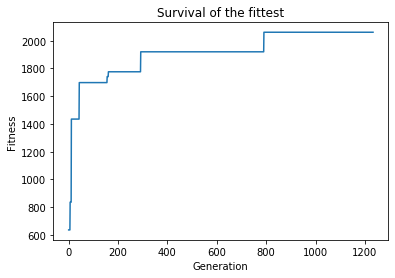

Generation Time:  133.24820566177368


In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

epochs = 10000

for e in range(epochs):
    current_time = time.time()
    generation, gen_fitness, w_fitness = generation_step(generation, flashback = False, verbose = False)
    fitness_hist.append(max(gen_fitness))
    clear_output(wait = True)
    #print('gen_fitness: ', gen_fitness)
    #print('w_fitness: ', w_fitness)

    plt.title('Survival of the fittest')
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.plot(fitness_hist)
    plt.show()

    print('Generation Time: ', time.time() - current_time)

In [19]:
env = generation[0].play(monitor = True)

In [20]:
import io
import base64
from IPython.display import HTML

env = generation[0].play(monitor = True)

video = io.open('./gym-results/openaigym.video.%s.video000000.mp4' % env.file_infix, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
    <video width="360" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
.format(encoded.decode('ascii')))

Exception ignored in: <function Monitor.__del__ at 0x000001E344BF5378>
Traceback (most recent call last):
  File "C:\Users\Arthur\Anaconda3\lib\site-packages\gym\wrappers\monitor.py", line 229, in __del__
    self.close()
  File "C:\Users\Arthur\Anaconda3\lib\site-packages\gym\wrappers\monitor.py", line 134, in close
    super(Monitor, self).close()
  File "C:\Users\Arthur\Anaconda3\lib\site-packages\gym\core.py", line 236, in close
    return self.env.close()
  File "C:\Users\Arthur\Anaconda3\lib\site-packages\gym\core.py", line 236, in close
    return self.env.close()
  File "C:\Users\Arthur\Anaconda3\lib\site-packages\gym\core.py", line 236, in close
    return self.env.close()
  File "C:\Users\Arthur\Anaconda3\lib\site-packages\nes_py\nes_env.py", line 338, in close
    raise ValueError('env has already been closed.')
ValueError: env has already been closed.
